## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

print(tf.__version__)
# Use TensorFlow v2.x

2.2.0


## Synthesising Data

Defining functions for creating time series data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Defining constants for synthesising data

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

Creating time series data

In [4]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

Updating with noise

In [5]:
series += noise(time, noise_level, seed=42)

Splitting the data

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Defining constants for windowning

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Defining function that converts windows for dataset

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Building a Model

- Defining the model
- Calling clear_session() releases the global graph state that Keras is holding on to; resets the counters used for naming layers and variables in Keras; and resets the learning phase. This helps avoid clutter from old models and layers, especially when memory is limited, and a common use-case for clear_session is releasing memory when building models and layers in a loop.

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

Defining Learning Rate Optimizer

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

Compiling

In [11]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

Fitting

In [12]:
history = model.fit(
    dataset, 
    epochs=100, 
    callbacks=[lr_schedule]
)

Epoch 1/100
31/31 [==============================] - 1s 48ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 38ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 38ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08574 
Epoch 7/100
31/31 [==============================] - 1s 39ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 37ms/step - loss: 17.1597 - 

31/31 [==============================] - 1s 34ms/step - loss: 5.2213 - mae: 5.6963 - lr: 3.5481e-0549 - ma
Epoch 73/100
31/31 [==============================] - 1s 33ms/step - loss: 5.9186 - mae: 6.4005 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 1s 44ms/step - loss: 6.1640 - mae: 6.6490 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 1s 36ms/step - loss: 6.7896 - mae: 7.2732 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 1s 35ms/step - loss: 5.2215 - mae: 5.7012 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 1s 39ms/step - loss: 5.5952 - mae: 6.0767 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 1s 36ms/step - loss: 5.3833 - mae: 5.8619 - lr: 7.0795e-0595 - m
Epoch 79/100
31/31 [==============================] - 1s 25ms/step - loss: 5.3766 - mae: 5.8558 - lr: 7.9433e-0570 - mae
Epoch 80/100
31/31 [==============================] - ETA: 0s - loss: 5.1743 - mae: 5.65

Visualising loss

[1e-08, 0.0001, 0, 30]

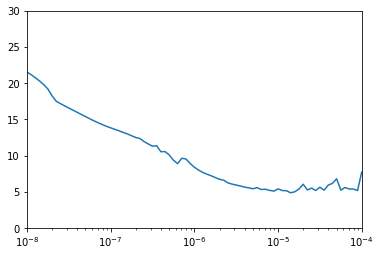

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Selecting lr=1e-5 and running the model again

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(
    loss="mse", 
    optimizer=tf.keras.optimizers.SGD(
        lr=1e-5, 
        momentum=0.9
    ),
    metrics=["mae"]
)

history = model.fit(
    dataset,
    epochs=500,
    verbose=0
)

## Forecasting

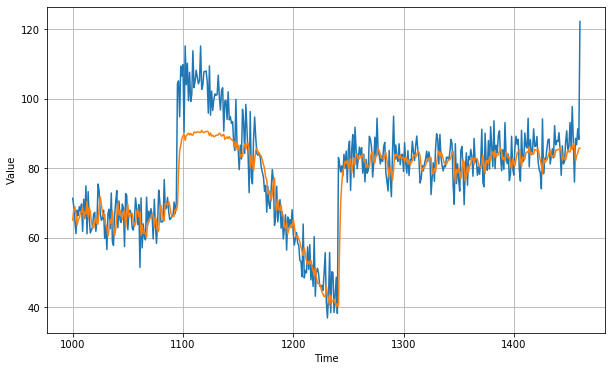

In [15]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## Error

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6518984

## Visualising MAE and Loss

<Figure size 432x288 with 0 Axes>

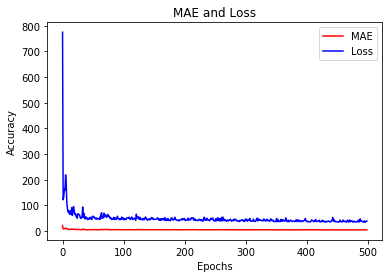

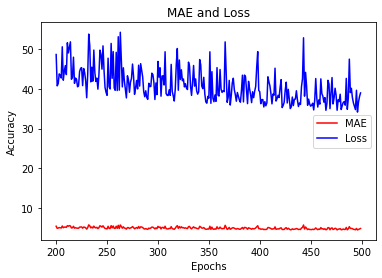

<Figure size 432x288 with 0 Axes>

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Improving Model Performance- Approach I

In [19]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

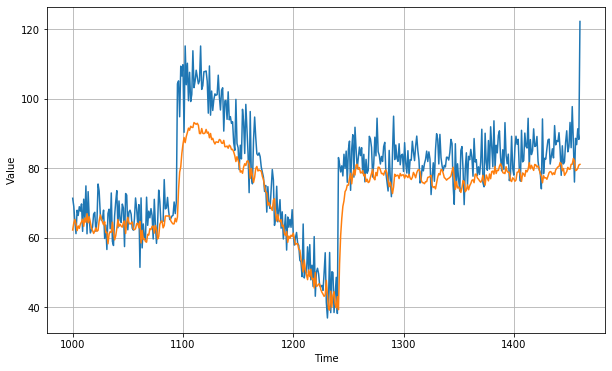

In [20]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.996652

## Improving Model Performance- Approach II 

In [22]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 42ms/step - loss: 327.8715
Epoch 2/100
31/31 [==============================] - 1s 41ms/step - loss: 108.0175
Epoch 3/100
31/31 [==============================] - 1s 40ms/step - loss: 89.7636
Epoch 4/100
31/31 [==============================] - 1s 40ms/step - loss: 88.7305
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 87.4052
Epoch 6/100
31/31 [==============================] - 1s 39ms/step - loss: 78.0780
Epoch 7/100
31/31 [==============================] - 1s 41ms/step - loss: 67.2469
Epoch 8/100
31/31 [==============================] - 1s 40ms/step - loss: 69.4297
Epoch 9/100
31/31 [==============================] - 2s 53ms/step - loss: 62.0385
Epoch 10/100
31/31 [==============================] - 2s 49ms/step - loss: 60.2090
Epoch 11/100
31/31 [==============================] - 2s 52ms/step - loss: 57.2370
Epoch 12/100
31/31 [==============================] - 1s 45ms/step - loss: 66.4509
Epoch 13/10

31/31 [==============================] - 1s 39ms/step - loss: 47.3950
Epoch 99/100
31/31 [==============================] - 1s 39ms/step - loss: 43.8798
Epoch 100/100
31/31 [==============================] - 1s 39ms/step - loss: 44.5385


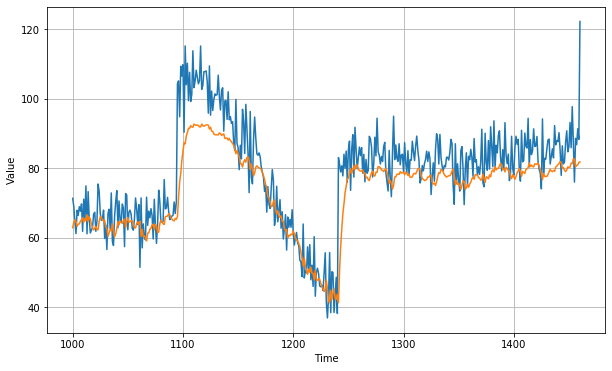

In [23]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.5336637